In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
df_orders = pd.read_csv("../../DataSets Grandes/PedidosYa_Customer-Orders-11-2020.csv",sep=";")

In [4]:
df_customers = pd.read_csv("../../DataSets Grandes/Sales_Orders order 2021-01-04T2033.csv",sep=",")

In [17]:
len(df_orders.Order_ID.unique())

74956

In [18]:
df_orders.columns = df_orders.columns.str.replace('"', '')
df_orders.rename({"\ufeffSKU_ID":"SKU_ID"},axis=1, inplace = True)

In [19]:
len(df_orders.SKU_ID.unique())

2401

In [20]:
df_orders.head(5)

,SKU_ID,Order_ID,Order_Date,Product_Name,Barcode_Array,Supplier_Names,Supplier_IDs,Listed_Unit_Price_New,Paid_Unit_Price_New,Unit_Discount,...,Total_COGS,Ordered_Quantity,Fulfilled_Quantity,Returned_Quantity,Original_Item_Subtotal,Original_Item_COGS,Adjusted_Item_Subtotal,Adjusted_Item_COGS,Store_ID,Store_Name
0,15500961,251959151,1/11/2020 00:43,Atún La Campagnola En Aceite 170 G.,"[""07793360005060"", ""7793360005060""]","LUDAJO SA,DULCENORT,VC Distribuidora SRL,Digo ...","44620,178054,25993,258156,17109,24254,37765,44...","160,00","160,00",0,...,"182,44",2,2,0.0,"320,00","182,44","320,00","182,44",163631,AR_8_Nordelta
1,15500918,251959151,1/11/2020 00:43,Azúcar Ledesma Clásica 1 Kg.,"[""07792540260138"", ""7792540260138""]","Ricardo Nini S.A.,Supermercados mayoristas Mak...","26,32","40,73","40,73",0,...,"31,29",1,1,0.0,"40,73","31,29","40,73","31,29",163631,AR_8_Nordelta
2,16953241,251959151,1/11/2020 00:43,Bolsas para residuos Asurín 50 x 70 cm. fuerte...,"[""7790117001733"", ""07790117001733""]",Supermercados mayoristas Makro SA,32,"197,82","197,82",0,...,"121,96",1,1,0.0,"197,82","121,96","197,82","121,96",163631,AR_8_Nordelta
3,18977828,251959151,1/11/2020 00:43,Choclo Amarillo Arcor Cremoso 300 G.,"[""7790580980801"", ""07790580980801""]","VC Distribuidora SRL,SFILIO ALFREDO D, GERMAN ...","17108,27502,37765,17109,25993,258182,13873,446...","57,45","57,45",0,...,"65,73",2,2,0.0,"114,91","65,73","114,91","65,73",163631,AR_8_Nordelta
4,15527698,251959151,1/11/2020 00:43,Chocolate Para Taza Águila 100 G.,"[""07790407031013"", ""7790407031013""]","LUDAJO SA,Dismarc,Canna Melis SRL,DULCENORT,TI...","44617,178054,24254,37765,24201,17108,25993,275...","136,73","136,73",0,...,"133,38",2,2,0.0,"273,45","133,38","273,45","133,38",163631,AR_8_Nordelta


In [8]:
df_customers.head(5)

,Unnamed: 0,Order Registered Date,Order ID,Salesforce ID,Restaurant Name,User ID,Confirmed Orders
0,1,29/11/2020,264553293,HKWROB,PedidosYa Market - Palermo,18997465,1
1,2,29/11/2020,264637558,45NPWL,PedidosYa Market - Boedo,17217991,1
2,3,29/11/2020,264595497,45YZX7,PedidosYa Market - Beccar,4053677,1
3,4,29/11/2020,264465290,45NPWJ,PedidosYa Market - Microcentro,16813550,1
4,5,29/11/2020,264339056,HKWROB,PedidosYa Market - Palermo,666396,1


In [10]:
#orders = df_orders.Order_ID.unique()
#orders = pd.DataFrame(orders, columns = ["Order_ID"])
#orders.head(2)

In [10]:
df_customers = df_customers[["Order ID","User ID","Confirmed Orders"]]

In [21]:
df_orders.shape

(413584, 22)

In [22]:
df_orders.isnull().sum()

SKU_ID                      0
Order_ID                    0
Order_Date                  0
Product_Name                0
Barcode_Array               0
Supplier_Names            826
Supplier_IDs              826
Listed_Unit_Price_New       0
Paid_Unit_Price_New         0
Unit_Discount               0
Unit_Cost_New               0
Total_Amount                0
Total_COGS                  0
Ordered_Quantity            0
Fulfilled_Quantity          0
Returned_Quantity           0
Original_Item_Subtotal      0
Original_Item_COGS          0
Adjusted_Item_Subtotal      0
Adjusted_Item_COGS          0
Store_ID                    0
Store_Name                  0
dtype: int64

In [24]:
df_orders_simple = df_orders.iloc[:,[0,1,13,-2]]

In [25]:
df_orders_simple.columns

Index(['SKU_ID', 'Order_ID', 'Ordered_Quantity', 'Store_ID'], dtype='object')

In [16]:
#df_simple = df_orders.loc[:,["Order_ID", "SKU_ID", "Ordered_Quantity","Store_ID"]]

In [26]:
df_orders_simple.head(2)

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID
0,15500961,251959151,2,163631
1,15500918,251959151,1,163631


In [27]:
df_full = df_orders_simple.merge(df_customers,how="inner",left_on="Order_ID",right_on="Order ID")

In [28]:
df_full.head()

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,Order ID,User ID,Confirmed Orders
0,15500961,251959151,2,163631,251959151,14988266,1
1,15500918,251959151,1,163631,251959151,14988266,1
2,16953241,251959151,1,163631,251959151,14988266,1
3,18977828,251959151,2,163631,251959151,14988266,1
4,15527698,251959151,2,163631,251959151,14988266,1


In [29]:
df_full["Confirmed Orders"].value_counts()

1    377915
0      4057
Name: Confirmed Orders, dtype: int64

In [30]:
df_full = df_full.drop(columns="Order ID")

In [31]:
df_full = df_full[df_full["Confirmed Orders"] == 1]

In [32]:
dummies = pd.get_dummies(df['SKU_ID'])
df_simple_dum = df_orders.drop('SKU_ID',axis = 1)

In [33]:
df_full_dummies = df_full.join(dummies)
df_full_dummies.head()

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,User ID,Confirmed Orders,15500909,15500912,15500913,15500915,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,15500961,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15500918,251959151,1,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16953241,251959151,1,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18977828,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15527698,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_full_dummies_reducido = df_full_dummies[:1200]

In [35]:
df_full_dummies_reducido.iloc[255,7]

1

In [36]:
test_multiply = df_full_dummies_reducido.iloc[:,6:].apply(lambda x: x*df_full_dummies_reducido["Ordered_Quantity"])

In [37]:
test_multiply.iloc[255]

15500909    0
15500912    2
15500913    0
15500915    0
15500917    0
           ..
28576439    0
28576441    0
28648645    0
28884458    0
28884461    0
Name: 255, Length: 2401, dtype: int64

In [203]:
df_final_reducido = df_full_dummies_reducido.iloc[:300,:6].join(test_multiply)

In [204]:
df_final_reducido.drop("SKU_ID",axis=1,inplace=True)
df_final_reducido.head()

,Order_ID,Ordered_Quantity,Store_ID,User ID,Confirmed Orders,15500909,15500912,15500913,15500915,15500917,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,1,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,1,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
df_final_reducido.drop(columns=["Ordered_Quantity","Confirmed Orders"],inplace=True)
df_final_reducido.head()

,Order_ID,Store_ID,User ID,15500909,15500912,15500913,15500915,15500917,15500918,15500920,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,163631,14988266,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
df_final_reducido.columns = df_final_reducido.columns.astype(str)

In [208]:
df_final_reducido.head()

,Order_ID,Store_ID,User ID,15500909,15500912,15500913,15500915,15500917,15500918,15500920,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,163631,14988266,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
df_final_reducido.groupby(["User ID",'Order_ID']).sum().head(6) #,"Store_ID"

Store_ID  15500909  15500912  15500913  15500915  15500917  \
User ID Order_ID                                                                
15290   251967482   1145417         0         0         0         0         0   
876305  251964234    492132         0         0         0         0         0   
946399  251966363    328088         0         0         0         0         0   
1399733 251968056    932982         0         0         0         0         0   
1431521 251966000   3088536         0         5         0         0         0   
        251966145   1684656         0         5         0         0         0   

                   15500918  15500920  15500921  15500923  ...  28575602  \
User ID Order_ID                                           ...             
15290   251967482         0         0         0         0  ...         0   
876305  251964234         0         0         0         0  ...         0   
946399  251966363         0         0         0         0  ...         0   
1399733 251968056         0         0         0         0  ...         0   
1431521 251966000         0         0         0         0  ...         0   
        251966145         0         0         0         0  ...         0   

                   28575603  28575604  28575605  28575607  28576439  28576441  \
User ID Order_ID                                                                
15290   251967482         0         0         0         0         0         0   
876305  251964234         0         0         0         0         0         0   
946399  251966363         0         0         0         0         0         0   
1399733 251968056         0         0         0         0         0         0   
1431521 251966000         0         0         0         0         0         0   
        251966145         0         0         0         0         0         0   

                   28648645  28884458  28884461  
User ID Order_ID                                 
15290   251967482         0         0         0  
876305  251964234         0         0         0  
946399  251966363         0         0         0  
1399733 251968056         0         0         0  
1431521 251966000         0         0         0  
        251966145         0         0         0  

[6 rows x 2402 columns]

In [212]:
df_final_reducido_grouped = df_final_reducido.groupby(["User ID",'Order_ID']).sum() #,"Store_ID"

In [213]:
df_final_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Columns: 2404 entries, Order_ID to 28884461
dtypes: int64(2404)
memory usage: 5.5 MB


In [214]:
df_final_reducido_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39 entries, (15290, 251967482) to (25049239, 251965286)
Columns: 2402 entries, Store_ID to 28884461
dtypes: int64(2402)
memory usage: 732.7 KB


In [ ]:
#Multiplicar dataframe total. Cantidad por cada valor dummy

#df_final = df_full_dummies.iloc[:,6:].apply(lambda x: x*df_full_dummies["Ordered_Quantity"])

# Pendiente 1: Matriz de features

In [215]:
df_final_reducido_grouped.columns.values

array(['Store_ID', '15500909', '15500912', ..., '28648645', '28884458',
       '28884461'], dtype=object)

In [216]:
X=df_final_reducido_grouped

# Esto es lo mismo que el dataframe del groupby

In [217]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train, X_test = train_test_split(X,test_size=0.2)

# Pendiente 2: KMeans/PCA

In [218]:
from sklearn.cluster import KMeans

#scaler=StandardScaler()
#X_scaled=scaler.fit_transform(X);

kmeans=KMeans(n_clusters=10,n_init=10,random_state=0) # Numero de repeticiones=10
kmeans.fit(X_train)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

In [219]:
X_train.loc[:,"15500912"]

User ID   Order_ID 
4461671   251965859    0
25049239  251965286    0
946399    251966363    0
3326049   251967006    0
14988266  251959151    0
4394485   251968496    0
4468527   251967065    0
22626739  251967880    1
1672232   251968540    0
14499056  251967373    0
20220712  251966428    0
1906307   251968380    0
23927572  251967496    0
7259084   251968640    0
15290     251967482    0
18759698  251966105    0
19397904  251966880    0
6759592   251966402    0
3662773   251967832    0
17208163  251965457    0
1431521   251966145    5
19559155  251967619    2
16596575  251968060    0
1970009   251967333    0
876305    251964234    0
1718569   251964728    5
6412807   251966520    0
5177239   251966108    0
1431521   251966000    5
18597224  251966411    0
12226667  251966268    0
Name: 15500912, dtype: int64

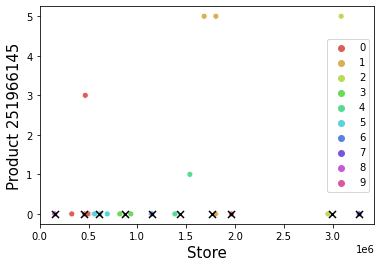

In [169]:
sns.scatterplot(x=X_train.iloc[:,0],y=X_train.loc[:,"15500912"],hue=labels,legend='full',palette=sns.color_palette("hls", 10));
plt.xlabel('Store',fontsize=15);plt.ylabel('Product 251966145',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

## Recomendación -> Item-Item

In [7]:
df_simple = df_simple.join(dummies)
df_simple[:5]

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,15500909,15500912,15500913,15500915,15500917,15500918,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,15500961,251959151,2,163631,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15500918,251959151,1,163631,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,16953241,251959151,1,163631,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18977828,251959151,2,163631,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15527698,251959151,2,163631,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_simple.drop(columns=["SKU_ID","Store_ID"], inplace = True)
df_simple[:5]

,Order_ID,Ordered_Quantity,15500909,15500912,15500913,15500915,15500917,15500918,15500920,15500921,...,28575602,28575603,28575604,28575605,28575607,28576439,28576441,28648645,28884458,28884461
0,251959151,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df_simple.iloc[369228]

SKU_ID               15500909
Order_ID            263449863
Ordered_Quantity            2
Store_ID               164043
Name: 369228, dtype: int64

In [ ]:
#df_simple2 = df_simple.iloc[:100,2:].apply(lambda x: x*df_simple.Ordered_Quantity for x in df_simple.columns)

In [94]:
df_simple.iloc[:10,2]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 15500909, dtype: uint8

In [9]:
df_simple.iloc[:len(df_simple),2] = df_simple["Ordered_Quantity"] * df_simple.iloc[:len(df_simple),2] #["15500909"]

In [ ]:
#df_simple.columns.get_loc()

In [10]:
df_simple.columns[0:10]

Index([        'Order_ID', 'Ordered_Quantity',           15500909,
                 15500912,           15500913,           15500915,
                 15500917,           15500918,           15500920,
                 15500921],
      dtype='object')

In [ ]:
df_simple.drop(columns=["Ordered_Quantity"], inplace = True)
df_simple.groupby()

In [69]:
df_simple.Order_ID = df_simple.Order_ID.astype(str)
df_simple.iloc[:,0] = df_simple.iloc[:,0].astype(str)
df_simple.Store_ID = df_simple.Store_ID.astype(str)

In [100]:
df_simple2.dtypes

SKU_ID            int64
Order_ID          int64
Order_Date       object
Product_Name     object
Barcode_Array    object
                  ...  
28576439          uint8
28576441          uint8
28648645          uint8
28884458          uint8
28884461          uint8
Length: 2423, dtype: object

In [71]:
X = df_simple #.iloc[:,[0,1,3,-1]]

In [74]:
X[:5]

,﻿SKU_ID,Order_ID,Ordered_Quantity,Store_ID
0,15500961,251959151,2,163631
1,15500918,251959151,1,163631
2,16953241,251959151,1,163631
3,18977828,251959151,2,163631
4,15527698,251959151,2,163631


In [75]:
%%time
#scaler=StandardScaler()
#X=scaler.fit_transform(data_clustering)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,18,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)   

2
4
6
8
10
12
14
16
Wall time: 2min 15s


In [157]:
inertia

[3.948959174135875e+18,
 1.993608209849802e+18,
 1.280789289268673e+18,
 9.616298272645027e+17,
 7.433867758762968e+17,
 6.151665495429709e+17,
 5.211802199013138e+17,
 4.496971258865625e+17]

In [76]:
k_val = range(0,2)
k_val

range(0, 2)

Text(0, 0.5, 'Inertia')

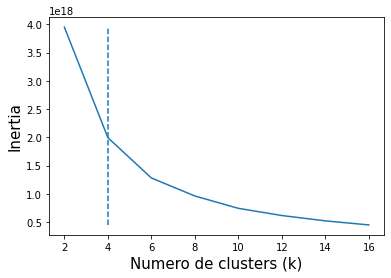

In [77]:
plt.plot(k_values,inertia);
plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

C:\Users\bruno\anaconda3\envs\dhdsblend37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


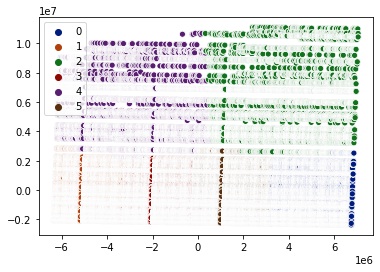

In [78]:
k=6;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X)

sns.scatterplot(X_transformed[:,0],X_transformed[:,1],hue=km.labels_,palette='dark');

C:\Users\bruno\anaconda3\envs\dhdsblend37\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


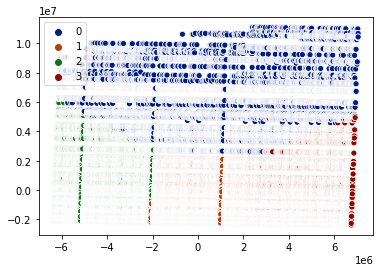

In [167]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X)

sns.scatterplot(X_transformed[:,0],X_transformed[:,1],hue=km.labels_,palette='dark');